In [1]:
import pyjags
import math
import numpy as np
import random
import pandas as pd
import scipy

import arviz as az
import matplotlib.pyplot as plt

# Chapter 5

In [2]:
import sys

In [3]:
JAGS_NA = -sys.float_info.max*(1-1e-15)

In [4]:
# 5.2
n_years = 25 #number of years
N1 = 30 # initial pop
mean_lambda = 1.02 #mean annual pop growth rate
sigma2_lambda = 0.02 #process (temporal) variation of the growth rate
sigma2_y = 20 # variance of the obs. error

In [5]:
# simulate pop. size under assumption of exponential growth

y = np.zeros(n_years)
N = np.zeros(n_years)
N[0] = N1

lambd = np.random.normal(mean_lambda, math.sqrt(sigma2_lambda), n_years)

for t in range(0, n_years  - 1):
    N[t+1] = N[t] * lambd[t]

for t in range(0, n_years - 1):
    y[t] = np.random.normal(N[t], math.sqrt(sigma2_y), 1)


In [6]:
model_52 = '''
model {

    # priors and constraints
    N.est[1] ~ dunif(0, 500) # prior for initial pop size
    mean.lambda ~ dunif(0, 10) #prior for the mean growth rate
    sigma.proc ~ dunif(0, 10) # prior for sd of state process
    sigma2.proc <- pow(sigma.proc, 2)
    tau.proc <- pow(sigma.proc, -2)
    sigma.obs ~ dunif(0, 100) # prior for sd of observation process
    sigma2.obs <- pow(sigma.obs, 2)
    tau.obs <- pow(sigma.obs, -2)

    # likelihood

    # state process
    for (t in 1:(T-1)){
        lambda[t] ~ dnorm(mean.lambda, tau.proc)
        N.est[t+1] <- N.est[t] * lambda[t]
    }

    #observation process
    for (t in 1:T) {
        y[t] ~ dnorm(N.est[t], tau.obs)
    }
}
'''

In [7]:
model_52_data = {
    "y": y,
    "T": n_years
}

In [8]:
inits = {}

A = np.zeros(25)
A[:] = JAGS_NA
A[0] = np.random.uniform(20, 40, 1)


inits['N.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)


In [9]:
inits

{'N.est': array([ 3.48672453e+001, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
        -1.79769313e+308]),
 'sigma.proc': array([1.90959477]),
 'mean.lambda': array([0.90048208]),
 'sigma.obs': array([3.47973323])}

In [10]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [11]:
n_iterations = 25000 # number of iterations
thinning = 3 # thinning
burnin = 10000 #burn-in
n_chains = 3

In [12]:
jags_model_52 = pyjags.Model(
    code = model_52,
    data = model_52_data,
    chains = n_chains, 
    init = inits
)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [13]:
jags_model_52.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:05, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:05, remaining 0:00:00


{}

In [14]:
jags_samples = jags_model_52.sample(n_iterations, vars=parameters)

sampling: iterations 27528 of 75000, elapsed 0:00:05, remaining 0:00:09
sampling: iterations 75000 of 75000, elapsed 0:00:13, remaining 0:00:00
sampling: iterations 75000 of 75000, elapsed 0:00:13, remaining 0:00:00


In [15]:
data_model52 = \
    az.from_pyjags(jags_samples)

az.summary(data_model52)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N.est[0],39.065,4.305,29.107,46.204,0.180,0.128,756.0,1036.0,1.01
N.est[1],30.860,3.145,24.784,37.478,0.055,0.039,3201.0,3340.0,1.02
N.est[2],28.742,2.968,22.750,34.755,0.048,0.034,3596.0,3119.0,1.02
N.est[3],26.373,2.885,20.524,32.074,0.052,0.037,2909.0,3308.0,1.01
N.est[4],21.291,3.493,16.181,28.442,0.215,0.152,256.0,1655.0,1.01
N.est[5],26.994,2.819,20.946,31.836,0.083,0.059,1188.0,3915.0,1.01
N.est[6],27.563,2.785,21.532,32.677,0.045,0.032,3736.0,3551.0,1.01
N.est[7],28.646,3.071,22.069,34.061,0.091,0.064,1363.0,2605.0,1.01
N.est[8],24.672,2.737,19.349,30.289,0.045,0.032,3478.0,3223.0,1.02
N.est[9],23.530,2.741,18.529,29.434,0.060,0.045,2223.0,2715.0,1.01


/Users/melvinwevers/opt/miniconda3/envs/vocapture/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_posterior, generating only 40 plots
  warnings.warn(


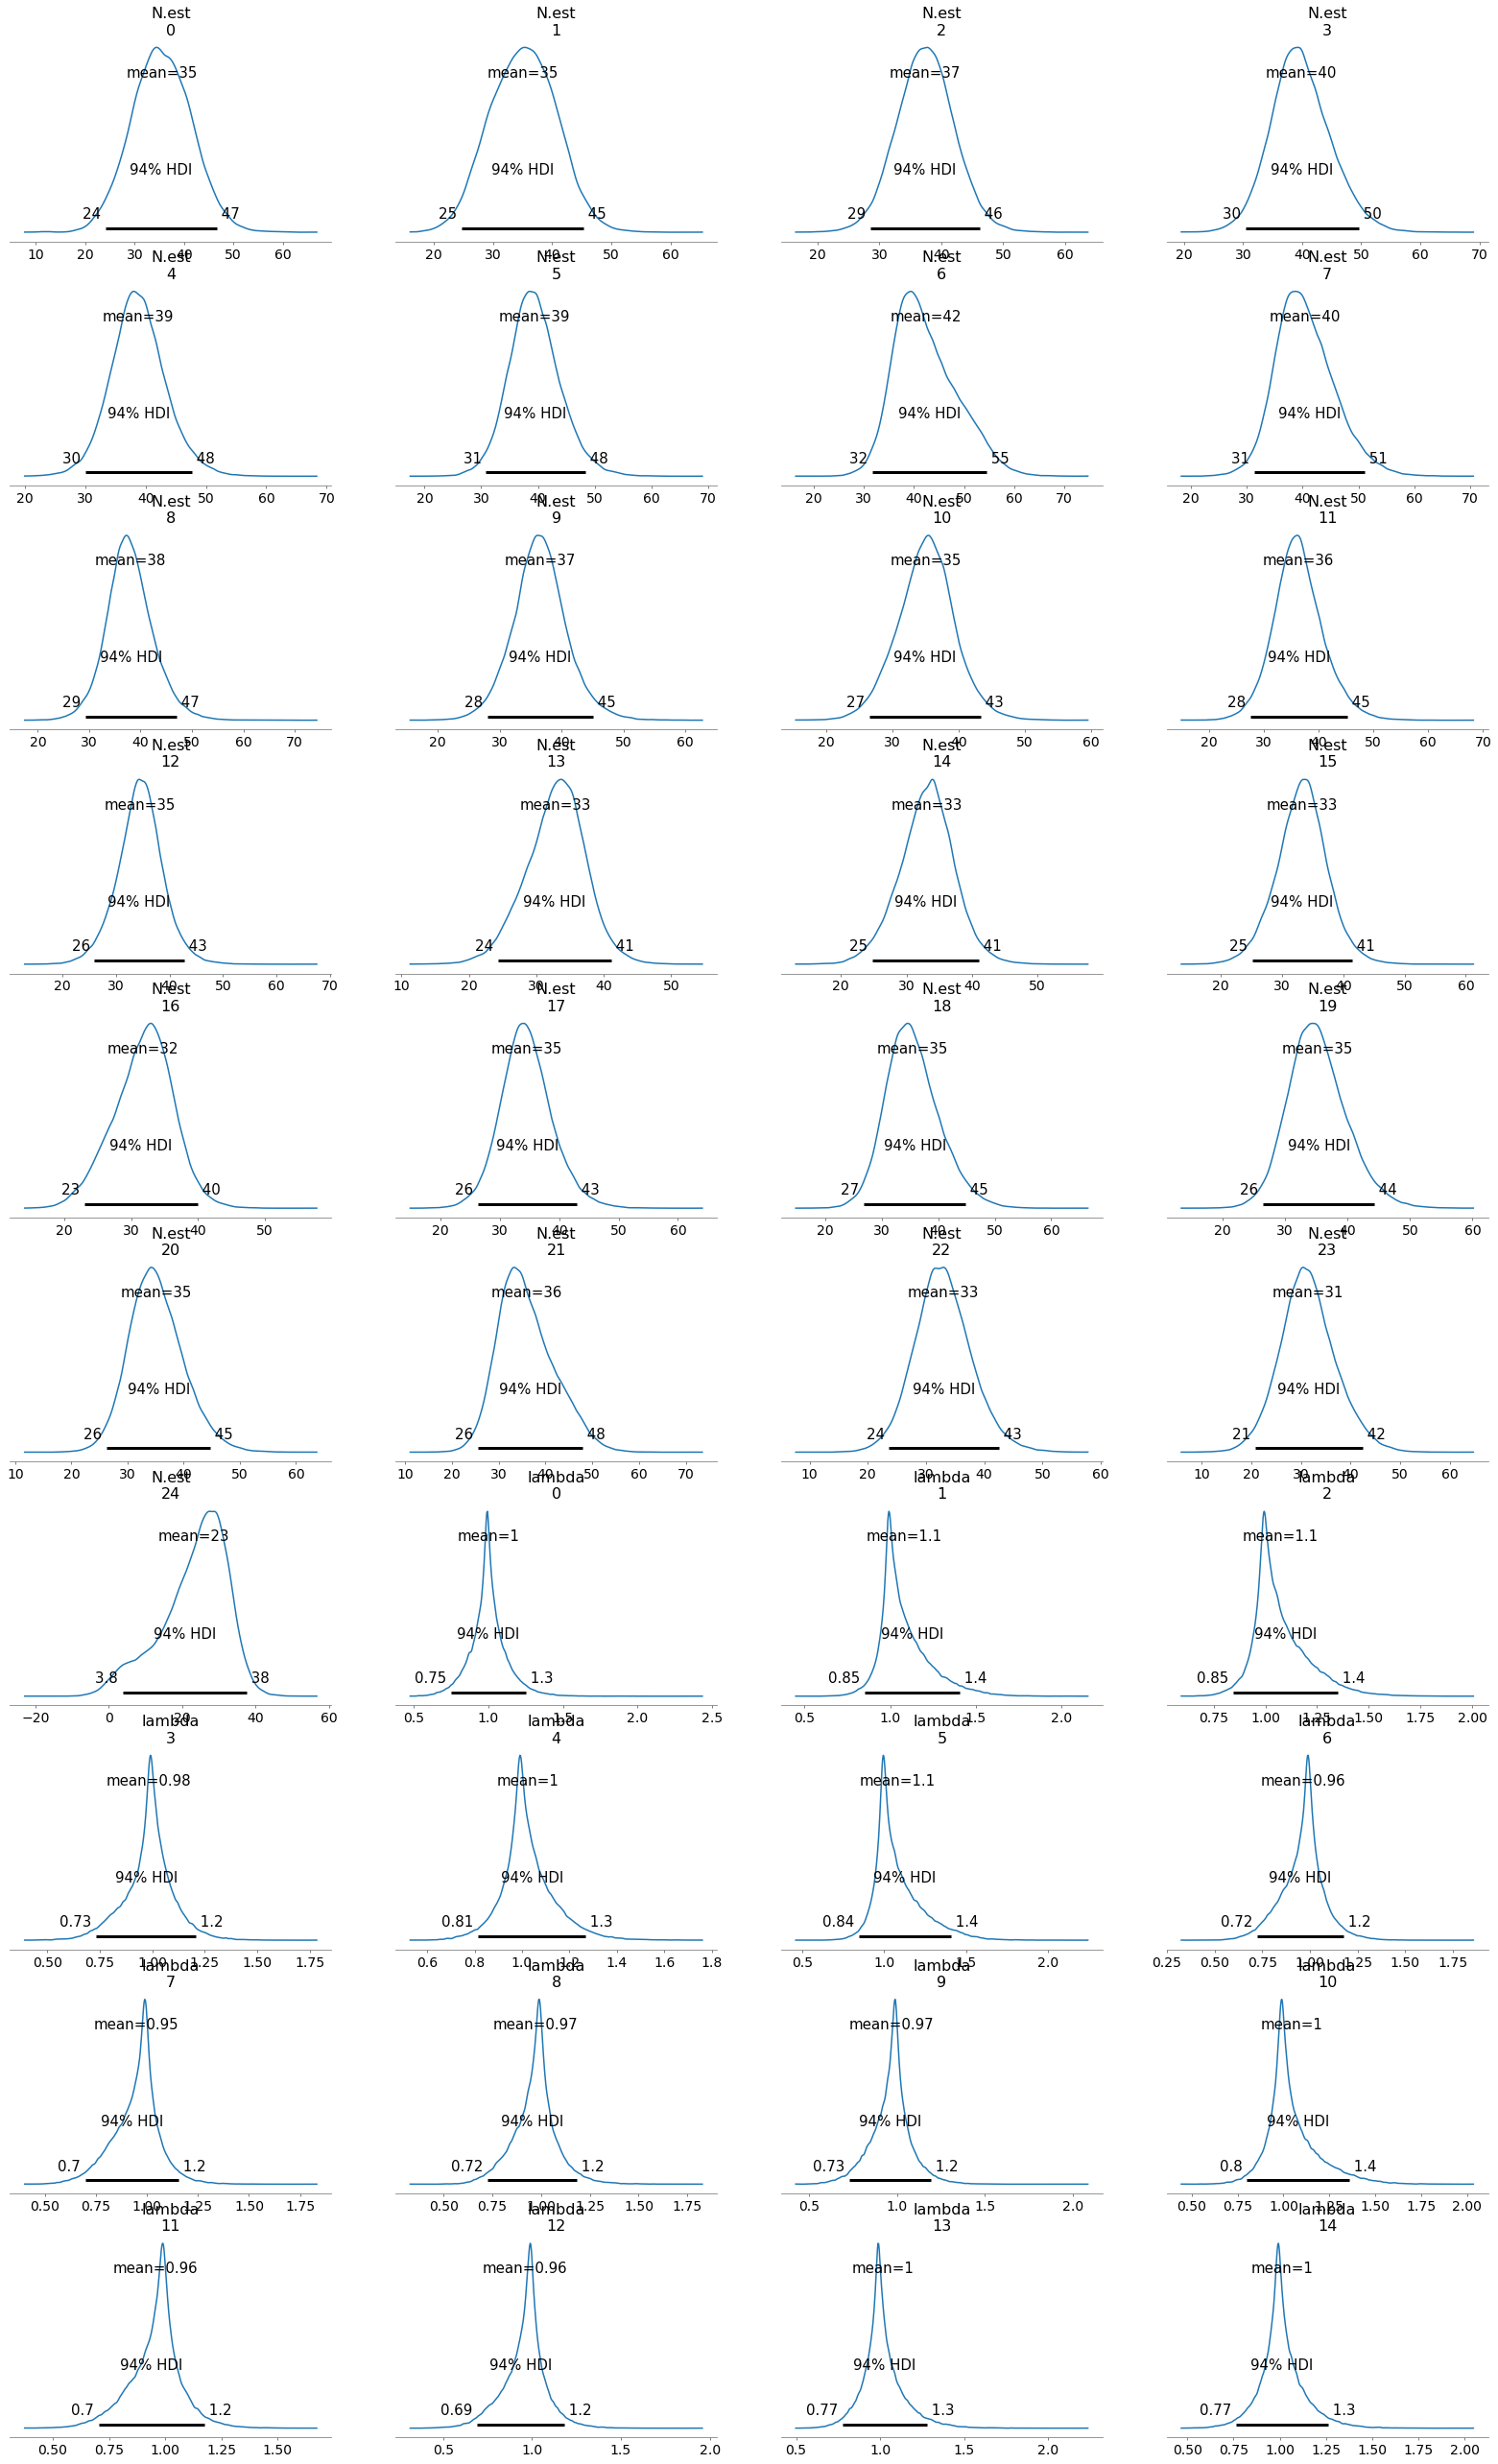

In [178]:
az.plot_posterior(data_model52);

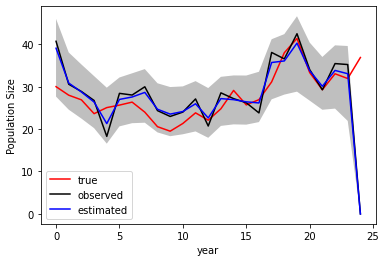

In [16]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, (n_years - 1)):
    fitted[i] = np.mean(jags_samples['N.est'][i])
    lower[i] = np.quantile(jags_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_samples['N.est'][i], 0.975)

plt.plot(range(0, n_years), N, color='red', label='true')
plt.plot(range(0, n_years), y, color='black', label='observed')
plt.plot(range(0, n_years), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, n_years), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

# 5.3 Systematic Bias in the Obs. Process

In [17]:
n_years = 25
N = np.repeat(50, n_years)

p = 0.7
y = np.zeros(25)

for t in range(0, n_years):
    y[t] = np.random.binomial(N[t], p, 1)


In [18]:
jags_data = {
    "y": y,
    "T": n_years
}

In [19]:
inits = {}

A = np.zeros(25)
A[:] = JAGS_NA
A[0] = np.random.uniform(30, 60, 1)


inits['N.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)


In [20]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [21]:
n_iterations = 25000 # number of iterations
thinning = 3 # thinning
burnin = 10000 #burn-in
n_chains = 3

In [22]:
model_53 = pyjags.Model(
    code = model_52,
    data = jags_data,
    chains = 3, 
    init = inits
)


adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [23]:
model_53.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:04, remaining 0:00:00


{}

In [24]:
model_53_samples = model_53.sample(25000, vars=parameters)

sampling: iterations 40215 of 75000, elapsed 0:00:07, remaining 0:00:06
sampling: iterations 68847 of 75000, elapsed 0:00:14, remaining 0:00:01
sampling: iterations 75000 of 75000, elapsed 0:00:15, remaining 0:00:00


In [25]:
data_model53 = \
    az.from_pyjags(model_53_samples)

In [26]:
az.summary(data_model53)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N.est[0],34.448,1.736,31.142,37.790,0.035,0.025,2356.0,4701.0,1.00
N.est[1],34.417,1.532,31.533,37.329,0.025,0.018,3716.0,5810.0,1.00
N.est[2],34.272,1.401,31.615,36.920,0.018,0.013,5943.0,6947.0,1.00
N.est[3],33.872,1.496,30.899,36.714,0.051,0.036,1110.0,381.0,1.00
N.est[4],34.775,1.423,32.155,37.491,0.033,0.024,1987.0,3546.0,1.00
N.est[5],34.977,1.454,32.355,37.814,0.031,0.022,2174.0,6158.0,1.00
N.est[6],35.137,1.562,32.386,38.212,0.041,0.029,1544.0,3912.0,1.00
N.est[7],35.031,1.667,32.177,38.597,0.062,0.045,982.0,402.0,1.00
N.est[8],33.420,1.565,30.160,36.252,0.064,0.045,846.0,352.0,1.00
N.est[9],33.484,1.340,30.869,35.920,0.023,0.017,3392.0,6684.0,1.00


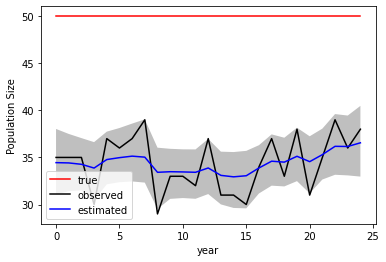

In [27]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i  in range(0, n_years):
    fitted[i] = np.mean(model_53_samples['N.est'][i])
    lower[i] = np.quantile(model_53_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(model_53_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

## Simulate counts using binomial distr.

In [28]:
n_years = 25
N = np.repeat(50, n_years)

lp = [-0.5 + 0.1 * x for x in range(0, n_years)]
p = scipy.stats.norm.cdf(lp)

y = np.zeros(25)

for t in range(0, n_years):
     y[t] = np.random.binomial(N[t], p[t], 1)


In [29]:
jags_data = {
    "y": y,
    "T": n_years
}

In [30]:
model_54 = pyjags.Model(
    code = model_52,
    data = jags_data,
    chains = n_chains, 
    init = inits
)



adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [31]:
model_54.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:05, remaining 0:00:00


{}

In [32]:
model_54_samples = model_54.sample(n_iterations, vars=parameters)

sampling: iterations 46659 of 75000, elapsed 0:00:09, remaining 0:00:06
sampling: iterations 71481 of 75000, elapsed 0:00:17, remaining 0:00:01
sampling: iterations 75000 of 75000, elapsed 0:00:18, remaining 0:00:00


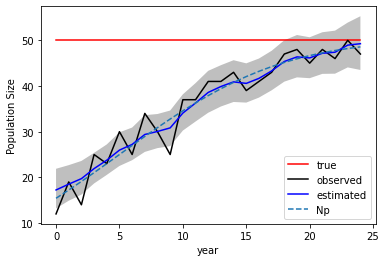

In [33]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, n_years):
    fitted[i] = np.mean(model_54_samples['N.est'][i])
    lower[i] = np.quantile(model_54_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(model_54_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.plot(N*p, label='Np', linestyle='dashed')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

# 5.4. Real example

In [34]:
model_54 = '''
model {
# Priors and constraints
logN.est[1] ~ dnorm(5.6, 0.01)       # Prior for initial population size
mean.r ~ dnorm(1, 0.001)             # Prior for mean growth rate
sigma.proc ~ dunif(0, 1)             # Prior for sd of state process
sigma2.proc <- pow(sigma.proc, 2)
tau.proc <- pow(sigma.proc, -2)
sigma.obs ~ dunif(0, 1)              # Prior for sd of observation process
sigma2.obs <- pow(sigma.obs, 2)
tau.obs <- pow(sigma.obs, -2)

# Likelihood
# State process
for (t in 1:(T-1)){
   r[t] ~ dnorm(mean.r, tau.proc)
   logN.est[t+1] <- logN.est[t] + r[t]
   }
   
# Observation process
for (t in 1:T) {
   y[t] ~ dnorm(logN.est[t], tau.obs)
   }

# Population sizes on real scale
for (t in 1:T) {
   N.est[t] <- exp(logN.est[t])
   }
}
'''

In [45]:
# House martin population data from Magden
p_years = 6 # Number of future years with predictions
B = np.zeros(p_years)
B[:] = JAGS_NA

A = np.array([271, 261, 309, 318, 231, 216, 208, 226, 195, 226, 233, 209, 226, 192, 191, 225, 245, 205, 191, 174])

A = np.log(A)

## repeated missing values, this is incorrect. fix. 
hm = np.concatenate([A, B])
years = range(1990, 2009+p_years)

In [46]:
jags_data = {
    "y": hm,
    "T": len(years)
}

In [47]:
len(jags_data['y'])

26

In [48]:
inits = {}

A = np.zeros(len(years))
A[:] = JAGS_NA
A[0] = np.random.normal(5.6, 0.1, 1)

inits['logN.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 1, 1)
inits['mean.r'] = np.random.normal(1)
inits['sigma.obs'] = np.random.uniform(0, 1, 1)

In [49]:
parameters = ['r', 'mean.r', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [50]:
n_iterations = 200000 # number of iterations
thinning = 6 # thinning
burnin = 100000 #burn-in
n_chains = 3

In [51]:
model_54_jags = pyjags.Model(
    code = model_54,
    data = jags_data,
    chains = n_chains,
    init = inits
)


adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [52]:
model_54_jags.sample(burnin, vars=[], thin=thinning)


sampling: iterations 111582 of 300000, elapsed 0:00:09, remaining 0:00:16
sampling: iterations 171933 of 300000, elapsed 0:00:21, remaining 0:00:15
sampling: iterations 213786 of 300000, elapsed 0:00:26, remaining 0:00:11
sampling: iterations 297216 of 300000, elapsed 0:00:34, remaining 0:00:00
sampling: iterations 300000 of 300000, elapsed 0:00:34, remaining 0:00:00


{}

In [53]:

jags_samples = model_54_jags.sample(n_iterations, vars=parameters)

sampling: iterations 86691 of 600000, elapsed 0:00:08, remaining 0:00:45
sampling: iterations 202326 of 600000, elapsed 0:00:17, remaining 0:00:33
sampling: iterations 262308 of 600000, elapsed 0:00:22, remaining 0:00:28
sampling: iterations 321573 of 600000, elapsed 0:00:28, remaining 0:00:24
sampling: iterations 379200 of 600000, elapsed 0:00:34, remaining 0:00:20
sampling: iterations 434775 of 600000, elapsed 0:00:41, remaining 0:00:16
sampling: iterations 487650 of 600000, elapsed 0:00:47, remaining 0:00:11
sampling: iterations 590832 of 600000, elapsed 0:00:56, remaining 0:00:01
sampling: iterations 600000 of 600000, elapsed 0:00:57, remaining 0:00:00


In [54]:
data_model54 = \
    az.from_pyjags(jags_samples)

az.summary(data_model54)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N.est[0],274.221,15.844,245.059,307.123,0.103,0.074,25267.0,31499.0,1.0
N.est[1],269.566,14.596,244.455,299.702,0.155,0.111,9469.0,38814.0,1.0
N.est[2],292.669,20.208,251.798,324.157,0.378,0.267,3168.0,16311.0,1.0
N.est[3],291.601,24.095,246.573,326.726,0.573,0.409,1835.0,16388.0,1.0
N.est[4],241.165,13.057,219.316,267.110,0.193,0.136,4648.0,43005.0,1.0
N.est[5],224.347,13.613,202.143,252.271,0.204,0.145,5195.0,24658.0,1.0
N.est[6],216.783,13.471,195.246,244.729,0.210,0.149,4778.0,19751.0,1.0
N.est[7],222.429,11.125,200.144,243.506,0.069,0.049,24843.0,38911.0,1.0
N.est[8],207.655,13.869,186.977,235.421,0.270,0.191,2788.0,19609.0,1.0
N.est[9],222.506,10.600,201.106,242.282,0.060,0.042,31153.0,55342.0,1.0


In [61]:
len(hm)

26

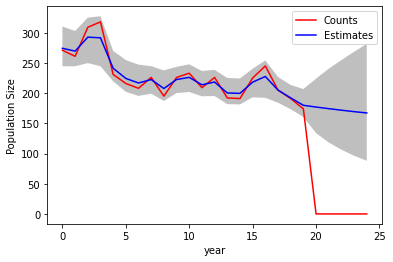

In [68]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)


for i in range(0, 25):
    fitted[i] = np.mean(jags_samples['N.est'][i])
    lower[i] = np.quantile(jags_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), np.exp(hm[:-1]), color='red', label='Counts')

plt.plot(range(0, 25), fitted, color='blue', label='Estimates')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

In [65]:
hm

array([ 5.60211882e+000,  5.56452041e+000,  5.73334128e+000,
        5.76205138e+000,  5.44241771e+000,  5.37527841e+000,
        5.33753808e+000,  5.42053500e+000,  5.27299956e+000,
        5.42053500e+000,  5.45103845e+000,  5.34233425e+000,
        5.42053500e+000,  5.25749537e+000,  5.25227343e+000,
        5.41610040e+000,  5.50125821e+000,  5.32300998e+000,
        5.25227343e+000,  5.15905530e+000, -1.79769313e+308,
       -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
       -1.79769313e+308, -1.79769313e+308])